In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.stats import norm

from astropy.io import fits

from coprofile import COGenerator

from likelihood import FunctionModelLikelihood

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [3]:
fmu_neg, fmu_fast = 0.066, 0.072

In [41]:
def plot_factors(t, neg, fast, slopes, sample=True):
    if len(np.shape(neg))==1:
        neg = np.array([neg])
    if len(np.shape(fast))==1:
        fast = np.array([fast])
    
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,n in enumerate(neg):
        ax.plot(t, n, label='Linear {:.2f}'.format(slopes[i]+1))
    ax.axhline(fmu_neg, ls='--', lw=2, c='red', label='Const')
    ax.set(xlim=(min(t),max(t)),
           xlabel='time [yrs]',
            ylim=(0.02,0.12),
            ylabel='f_mu_neg')
    ax.legend(loc='lower left', fontsize=10)
    plt.title('Linear Model f_neg Fixed in Present')
    
    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,f in enumerate(fast):
        ax.plot(t, f, label='Linear {:.2f}'.format(slopes[i]+1))
    ax.axhline(fmu_fast, ls='--', lw=2, c='red', label='Const')
    ax.set(xlim=(min(t),max(t)),
            xlabel='time [yrs]',
            ylim=(0.02,0.12),
            ylabel='f_mu_fast')
    ax.legend(loc='lower left', fontsize=10)
    plt.title('Linear Model f_fast Fixed in Present')

In [39]:
def plot_profiles(profiles, slopes, sample=False):
    if len(np.shape(np.array(profiles))) == 0:
        p = np.array([profiles])
    else:
        p = np.array(profiles)
    

    fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
    for i,profile in enumerate(p):
        ax.plot(profile.z, profile.CO, label='Linear {:.2f}'.format(slopes[i]+1))
    ax.plot(const_profile.z, const_profile.CO, ls='--', lw=2, c='red', label='Const'.format(slopes[i]))
    if sample:
        z_samp, CO_samp, dCO_samp = p[0].sample_z()
        ax.errorbar(z_samp, CO_samp, yerr=dCO_samp, fmt='.')
    ax.set(xlim=(90,300),
            xlabel='depth [m]',
            ylim=(0,35),
            ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
    ax.legend(loc='lower right', fontsize=10)
    plt.title('Linear Model CO Profiles Fixed in Present')

In [6]:
generator = COGenerator('models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits')

In [7]:
const_profile = generator.generate()

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.14it/s]


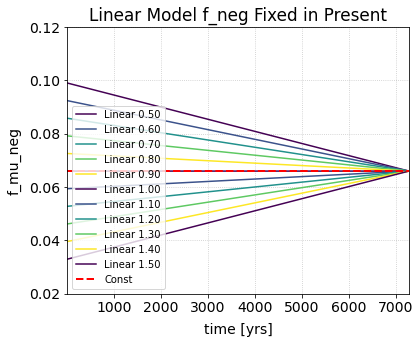

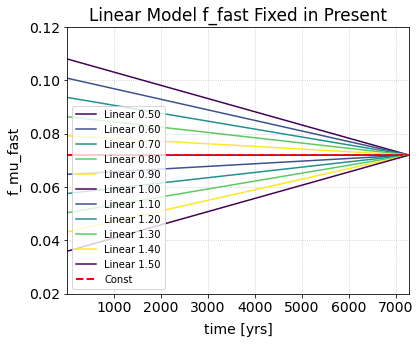

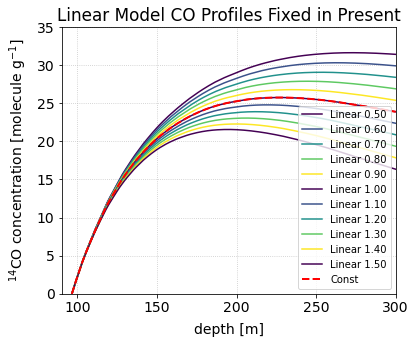

In [42]:
slopes = np.arange(-0.5, 0.6, 0.1)

t = generator.t
tmax = np.max(t)
tmin = np.min(t)


neg = fmu_neg * (1 + np.expand_dims(slopes, axis=1) * (t-tmax)/(tmax-tmin))
fast = fmu_fast * (1 + np.expand_dims(slopes, axis=1) * (t-tmax)/(tmax-tmin))

linear_profiles = []
for i in tqdm(range(len(slopes))):
    linear_profiles.append(generator.generate(neg[i], fast[i]))
plot_factors(t, neg, fast, slopes)
    
linear_profiles = np.array(linear_profiles)

plot_profiles(linear_profiles, slopes)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.12it/s]


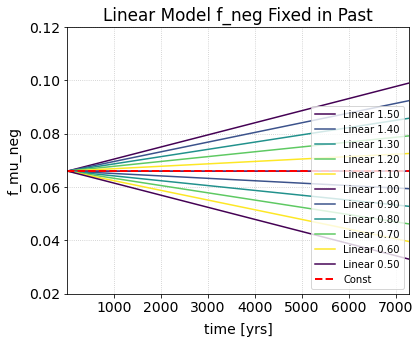

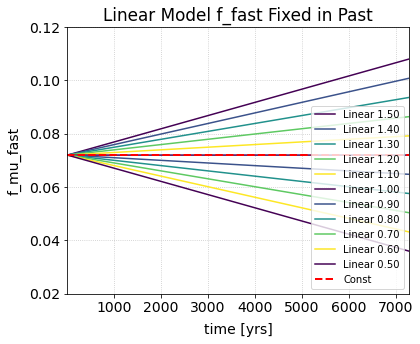

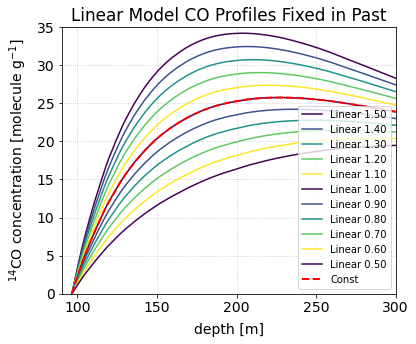

In [35]:
slopes = np.arange(0.5, -0.6, -0.1)

t = generator.t
tmax = np.max(t)
tmin = np.min(t)

neg = fmu_neg * (1 + np.expand_dims(slopes, axis=1) * (t-tmin)/(tmax-tmin))
fast = fmu_fast * (1 + np.expand_dims(slopes, axis=1) * (t-tmin)/(tmax-tmin))

linear_profiles = []
for i in tqdm(range(len(slopes))):
    linear_profiles.append(generator.generate(neg[i], fast[i]))
plot_factors(t, neg, fast, slopes)
    
linear_profiles = np.array(linear_profiles)

plot_profiles(linear_profiles, slopes)

In [10]:
def linear_func(t, theta):
    amp = 1 + theta[0] * (t-max(t))/(max(t)-min(t))
    return fmu_neg*amp, fmu_fast*amp

In [11]:
generator = COGenerator('models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits')

In [12]:
const_profile = generator.generate()

In [13]:
linear_models = FunctionModelLikelihood(generator, linear_func, [(-0.5,0.5)])

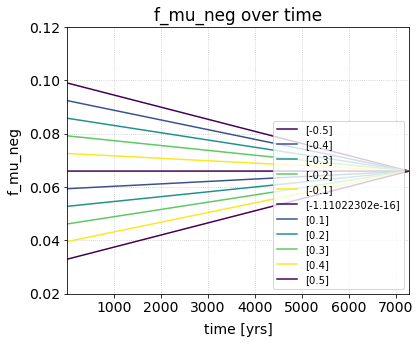

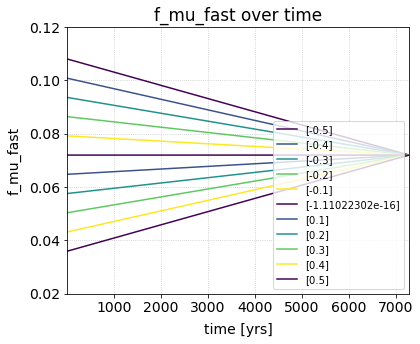

In [14]:
thetas = np.expand_dims(np.arange(-0.5,0.6,0.1),axis=1)
linear_models.plot_factors(thetas)

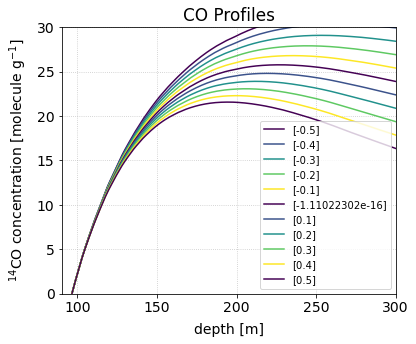

In [15]:
linear_models.plot_profiles(thetas)

In [8]:
z_samp, CO_samp, dCO_samp = const_profile.sample_z()

print(linear_models.likelihood(z_samp, CO_samp, dCO_samp))

(4.396865714015534e-05, 4.171876254131905e-09)
